In [28]:
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve,
    classification_report, confusion_matrix
)

import matplotlib.pyplot as plt

In [29]:
DATA_DIR = Path("../data/processed")


TRAIN_PATH = DATA_DIR / "application_train_features.parquet"

df = pd.read_parquet(TRAIN_PATH)
df.shape, df.columns[:10]

((307511, 18),
 Index(['target', 'amt_income_total_log', 'amt_credit_log', 'amt_annuity_log',
        'debt_to_income', 'is_currently_employed', 'years_employed',
        'ext_source_1', 'ext_source_2', 'ext_source_3'],
       dtype='object'))

In [30]:
df.head()

,target,amt_income_total_log,amt_credit_log,amt_annuity_log,debt_to_income,is_currently_employed,years_employed,ext_source_1,ext_source_2,ext_source_3,bureau_sum_debt_log,bureau_active_cnt,bureau_sum_overdue,name_contract_type,name_income_type,name_education_type,name_family_status,name_housing_type
0,1,12.218500,12.915581,10.114619,0.121978,1,1.745205,0.083037,0.262949,0.139376,12.4122,2.0,0.0,Cash loans,Working,Secondary / secondary special,Single / not married,House / apartment
1,0,12.506181,14.072865,10.482892,0.132217,1,3.254795,0.311267,0.622246,NaN,0.0000,1.0,0.0,Cash loans,State servant,Higher education,Married,House / apartment
2,0,11.119898,11.813037,8.817446,0.100000,1,0.616438,NaN,0.555912,0.729567,0.0000,0.0,0.0,Revolving loans,Working,Secondary / secondary special,Single / not married,House / apartment
3,0,11.813037,12.652947,10.298481,0.219900,1,8.326027,NaN,0.650442,NaN,NaN,NaN,NaN,Cash loans,Working,Secondary / secondary special,Civil marriage,House / apartment
4,0,11.707678,13.148033,9.992711,0.179963,1,8.323288,NaN,0.322738,NaN,0.0000,0.0,0.0,Cash loans,Working,Secondary / secondary special,Single / not married,House / apartment


In [31]:
TARGET_COL = "target"

features_numeric_transformed = [
    # affordability
    "amt_income_total_log",
    "amt_credit_log",
    "amt_annuity_log",
    "debt_to_income",

    # employment
    "is_currently_employed",
    "years_employed",

    # external risk
    "ext_source_1",
    "ext_source_2",
    "ext_source_3",

    # bureau
    "bureau_sum_debt_log",
    "bureau_active_cnt",
    "bureau_sum_overdue",
]

features_categorical = [
    "name_contract_type",
    "name_income_type",
    "name_education_type",
    "name_family_status",
    "name_housing_type",
]

FEATURES = features_numeric_transformed + features_categorical

In [32]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features_numeric_transformed),
        ("cat", categorical_transformer, features_categorical),
    ]
)

In [33]:
set(FEATURES) - set(df.columns)

set()

In [34]:
pd.DataFrame({
    "count": df["target"].value_counts().sort_index(),
    "percentage (%)": df["target"].value_counts(normalize=True).sort_index() * 100
})

,count,percentage (%)
target,,
0,282686,91.927118
1,24825,8.072882


In [35]:
#train and test split

In [36]:
X = df[FEATURES]
y = df[TARGET_COL]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [37]:
# baseline - LogisticRegression

In [38]:
clf_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

In [39]:
clf_lr.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [40]:
proba_val = clf_lr.predict_proba(X_val)[:, 1]

print("ROC-AUC:", roc_auc_score(y_val, proba_val))
print("PR-AUC :", average_precision_score(y_val, proba_val))

ROC-AUC: 0.7346112945915191
PR-AUC : 0.21634232903874095


In [41]:
y_pred_05 = (proba_val >= 0.5).astype(int)

print(classification_report(y_val, y_pred_05, digits=4))
print(confusion_matrix(y_val, y_pred_05))

              precision    recall  f1-score   support

           0     0.9588    0.6843    0.7986     56538
           1     0.1561    0.6653    0.2529      4965

    accuracy                         0.6827     61503
   macro avg     0.5575    0.6748    0.5258     61503
weighted avg     0.8940    0.6827    0.7545     61503

[[38687 17851]
 [ 1662  3303]]


In [42]:
precisions, recalls, thresholds = precision_recall_curve(y_val, proba_val)

len(precisions), len(recalls), len(thresholds)

(61504, 61504, 61503)

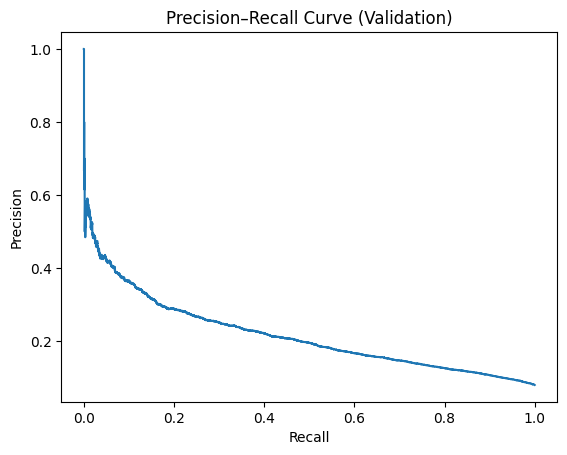

In [43]:
plt.figure()
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Validation)")
plt.show()

In [44]:

thresholds_full = np.append(thresholds, 1.0)

target_recall = 0.70

mask = recalls >= target_recall

recalls_sel = recalls[mask]
precisions_sel = precisions[mask]
thresholds_sel = thresholds_full[mask]

best_idx = np.argmax(precisions_sel)

best_threshold = thresholds_sel[best_idx]
best_recall = recalls_sel[best_idx]
best_precision = precisions_sel[best_idx]

best_threshold, best_recall, best_precision

(np.float64(0.47530231676075885),
 np.float64(0.7021148036253776),
 np.float64(0.14763054249777666))

In [45]:
y_pred_opt = (proba_val >= best_threshold).astype(int)

print("Chosen threshold:", best_threshold)
print(classification_report(y_val, y_pred_opt, digits=4))
print(confusion_matrix(y_val, y_pred_opt))

Chosen threshold: 0.47530231676075885
              precision    recall  f1-score   support

           0     0.9610    0.6440    0.7712     56538
           1     0.1476    0.7021    0.2440      4965

    accuracy                         0.6487     61503
   macro avg     0.5543    0.6731    0.5076     61503
weighted avg     0.8953    0.6487    0.7286     61503

[[36411 20127]
 [ 1479  3486]]


Threshold Selection
Given the severe class imbalance (~8% default rate), a default threshold of 0.5 is not optimal.
We selected the classification threshold based on the Precision–Recall trade-off, targeting a minimum recall of 70% to prioritize the detection of high-risk applicants.
At a threshold of 0.48, the model captures approximately 70% of default cases on the validation set, at the cost of lower precision, which is acceptable in a credit risk screening context.


In [46]:
# tree model

HistGradientBoostingClassifier was used as a second, non-linear model to capture complex interactions between risk factors.
Compared to the logistic regression baseline, the gradient boosting model achieved higher ROC-AUC and PR-AUC, indicating improved ranking and risk concentration among high-risk applicants.

In [47]:
numeric_transformer_tree = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer_tree = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_tree, features_numeric_transformed),
        ("cat", categorical_transformer_tree, features_categorical),
    ],
    remainder="drop"
)

In [48]:
clf_hgb = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", HistGradientBoostingClassifier(
        max_depth=6,
        learning_rate=0.05,
        max_iter=400,
        random_state=42
    ))
])

clf_hgb.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [49]:
proba_val_hgb = clf_hgb.predict_proba(X_val)[:, 1]

print("HGB ROC-AUC:", roc_auc_score(y_val, proba_val_hgb))
print("HGB PR-AUC :", average_precision_score(y_val, proba_val_hgb))

HGB ROC-AUC: 0.745548203514666
HGB PR-AUC : 0.23664203446841775


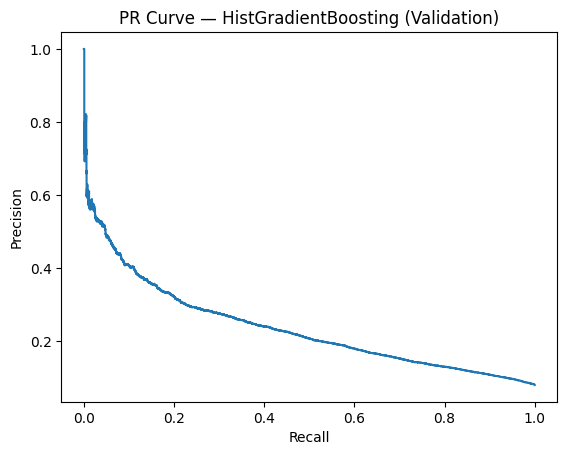

In [50]:
prec_hgb, rec_hgb, thr_hgb = precision_recall_curve(y_val, proba_val_hgb)

plt.figure()
plt.plot(rec_hgb, prec_hgb)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve — HistGradientBoosting (Validation)")
plt.show()

In [51]:
thr_full = np.append(thr_hgb, 1.0)
target_recall = 0.70

mask = rec_hgb >= target_recall
prec_sel = prec_hgb[mask]
rec_sel  = rec_hgb[mask]
thr_sel  = thr_full[mask]

best_idx = np.argmax(prec_sel)

best_thr_hgb = thr_sel[best_idx]
best_rec_hgb = rec_sel[best_idx]
best_prec_hgb = prec_sel[best_idx]

best_thr_hgb, best_rec_hgb, best_prec_hgb

(np.float64(0.07577527523582159),
 np.float64(0.7001007049345418),
 np.float64(0.15310077519379844))

In [52]:
y_pred_hgb = (proba_val_hgb >= best_thr_hgb).astype(int)

print("Chosen threshold (HGB):", best_thr_hgb)
print(classification_report(y_val, y_pred_hgb, digits=4))
print(confusion_matrix(y_val, y_pred_hgb))

Chosen threshold (HGB): 0.07577527523582159
              precision    recall  f1-score   support

           0     0.9616    0.6599    0.7827     56538
           1     0.1531    0.7001    0.2513      4965

    accuracy                         0.6632     61503
   macro avg     0.5574    0.6800    0.5170     61503
weighted avg     0.8964    0.6632    0.7398     61503

[[37310 19228]
 [ 1489  3476]]


In [60]:
df_eval = pd.DataFrame({
    "target": y_val,
    "score": proba_val_hgb
})

In [53]:
from pathlib import Path
import joblib


Path("models").mkdir(exist_ok=True)

joblib.dump(clf_hgb, "../models/model.joblib")

print("✅ HGB pipeline saved to models/model.joblib")

✅ HGB pipeline saved to models/model.joblib


In [62]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))

In [63]:
from model_evaluation import make_score_band_table, policy_summary

In [64]:
score_band_tbl = make_score_band_table(
    y_true=y_val,
    y_score=proba_val_hgb,
    threshold=best_thr_hgb
)

score_band_tbl

,score_band,application_cnt,application_share_pct,default_rate_pct,default_cnt,cum_application_share_pct,cum_default_capture_pct,threshold_band
0,0.00–0.20,57046,92.75,6.45,3679,92.75,74.10,⬅ threshold
1,0.20–0.40,4100,6.67,26.80,1099,99.42,96.23,
2,0.40–0.60,344,0.56,51.74,178,99.98,99.82,
3,0.60–0.80,13,0.02,69.23,9,100.00,100.00,


In [65]:
policy_summary(
    y_true=y_val,
    y_score=proba_val_hgb,
    threshold=best_thr_hgb
)

{'threshold': 0.07577527523582159,
 'reject_rate_pct': np.float64(36.92),
 'approve_rate_pct': np.float64(63.08),
 'rejected_bad_rate_pct': np.float64(15.31),
 'approved_bad_rate_pct': np.float64(3.84),
 'bad_capture_recall_pct': np.float64(70.01),
 'n_total': 61503,
 'n_rejected': 22704,
 'n_approved': 38799}

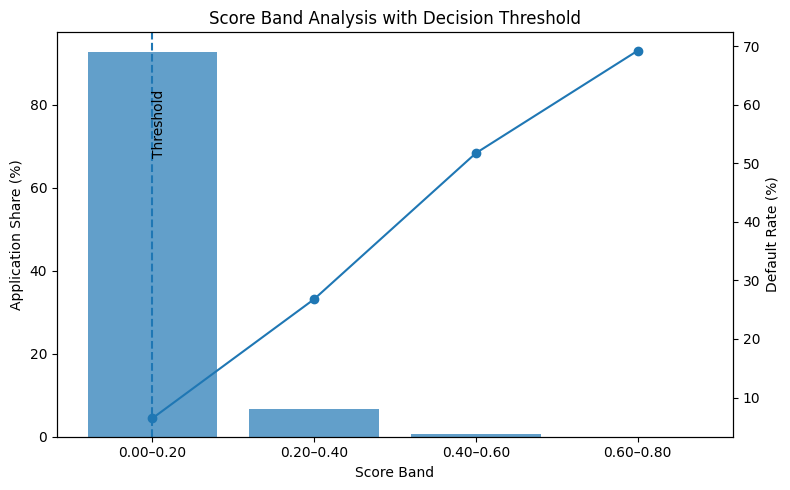

In [66]:


fig, ax1 = plt.subplots(figsize=(8, 5))

# bar: application share
ax1.bar(
    score_band_tbl["score_band"],
    score_band_tbl["application_share_pct"],
    alpha=0.7
)
ax1.set_ylabel("Application Share (%)")
ax1.set_xlabel("Score Band")

# line: default rate
ax2 = ax1.twinx()
ax2.plot(
    score_band_tbl["score_band"],
    score_band_tbl["default_rate_pct"],
    marker="o"
)
ax2.set_ylabel("Default Rate (%)")

# threshold annotation
thr_band = score_band_tbl.loc[
    score_band_tbl["threshold_band"] != "", "score_band"
]
if not thr_band.empty:
    ax1.axvline(
        x=thr_band.values[0],
        linestyle="--"
    )
    ax1.text(
        thr_band.values[0],
        max(score_band_tbl["application_share_pct"]) * 0.9,
        "Threshold",
        rotation=90,
        va="top"
    )

plt.title("Score Band Analysis with Decision Threshold")
plt.tight_layout()
plt.show()

In [68]:
dashboard_dir = Path("..") / "dashboard"
dashboard_dir.mkdir(exist_ok=True)

score_band_tbl.to_csv(
    dashboard_dir / "score_band_summary.csv",
    index=False
)

policy_df = pd.DataFrame([policy_summary(
    y_true=y_val,
    y_score=proba_val_hgb,
    threshold=best_thr_hgb
)])

policy_df.to_csv(
    dashboard_dir / "policy_summary.csv",
    index=False
)

print("Exported to:", dashboard_dir.resolve())

Exported to: /Users/haiou/Ironhacker/home-credit-risk-analytics/dashboard
